<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc

from sklearn.utils import shuffle

In [2]:
data = pd.read_csv('/datasets/Churn.csv')

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
# Tenure column has some absenct values, let's fill them with a median
data.Tenure.fillna(data.Tenure.median(), inplace=True)

In [6]:
data.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [7]:
# divide dataset into features and target
# I assume that 'RowNumber', 'CustomerId', and 'Surname' columns are irrelevant for a model training
features = data.iloc[:, 3:13]
target = data.iloc[:, -1]
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
dtypes: float64(3), int64(5), object(2)
memory usage: 781.4+ KB


In [8]:
# разделим данные на обучающую, валидационную и тестовую выборки с соотношении 60%-20%-20%)
# выделяем 20% данных датасета для тестовой выборки
x, features_test, y, target_test = train_test_split(
                                        features, 
                                        target, 
                                        test_size=0.2, 
                                        random_state=12345,
                                        stratify=target)

# выделяем 25% для валидационной выборки от 80% с прошлого шага (20% от общего датасета)
features_train, features_valid, target_train, target_valid = train_test_split(
                                        x, 
                                        y, 
                                        test_size=0.25, 
                                        random_state=12345,
                                        stratify=y)

In [9]:
# sklearn version on the server doesn't support 'get_feature_names_out' and 'sparse_output',
# so 'get_feature_names' and 'sparse' are used instead

# categorical columns (not ordinal) to be encoded
categorical_columns = ['Geography', 'Gender']

# creating one-hot encoding object
# drop='if_binary' because perfectly collinear features cause problems (from scikit docs)
# sparse_output=False because mentor in Pachka said to do so
ohe = OneHotEncoder(sparse=False, drop='first')

# fit and transform categorical columns
ohe_train_vals = ohe.fit_transform(features_train[categorical_columns].values)
ohe_test_vals = ohe.transform(features_test[categorical_columns].values)
ohe_valid_vals = ohe.transform(features_valid[categorical_columns].values)

# transform them into Pandas df for convenience
ohe_train = pd.DataFrame(ohe_train_vals, index=features_train.index, columns=ohe.get_feature_names())
ohe_test = pd.DataFrame(ohe_test_vals, index=features_test.index, columns=ohe.get_feature_names())
ohe_valid = pd.DataFrame(ohe_valid_vals, index=features_valid.index, columns=ohe.get_feature_names())

# delete original categorical columns and add encoded ones
features_train = features_train.drop(categorical_columns, axis=1)
features_train = features_train.join(ohe_train) 

features_test = features_test.drop(categorical_columns, axis=1)
features_test = features_test.join(ohe_test) 

features_valid = features_valid.drop(categorical_columns, axis=1)
features_valid = features_valid.join(ohe_valid)

In [10]:
pd.options.mode.chained_assignment = None

# standardise numerical values
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'IsActiveMember', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric]  = scaler.transform(features_test[numeric])

In [11]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,x0_Germany,x0_Spain,x1_Male
5536,-0.143332,0.577533,-0.001274,-1.220573,0.797767,1,0.967527,1.029613,0.0,1.0,1.0
8530,1.632702,-0.564119,-1.092954,0.435807,-0.916018,1,-1.033563,0.237986,0.0,0.0,0.0
1762,1.116413,-0.468981,-1.456847,1.245822,-0.916018,1,0.967527,-0.686104,0.0,0.0,0.0
9090,1.643028,0.006707,-0.001274,-1.220573,-0.916018,1,-1.033563,-0.391097,0.0,0.0,0.0
8777,-0.484083,-1.420358,-1.456847,1.421989,0.797767,1,-1.033563,-1.361559,0.0,1.0,1.0


Мы загрузили датасет, проверили наличие отстутствущих значний. Пропуски с столбце Tenure заполнили медианой. Преобразовали категориальные данные с помощью one-hot encoding. Стандартизировли числовые значения с помощью StandardScaler.

## Исследование задачи

**DecisionTreeClassifier**

In [12]:
# let's test DecisionTreeClassifier with various hyperparameters
best_model = None
best_result = 0
best_criterion = None
criterions = ["entropy", "gini"] 
best_depth = 0
# The log_loss option for the parameter criterion was added only in the latest scikit-learn version 1.1.2
for criterion in criterions:
    for depth in range(1, 16):
        model = DecisionTreeClassifier(criterion=criterion, random_state=12345, max_depth=depth)
        model.fit(features_train, target_train) 
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid) 
        if result > best_result:
            best_model = model 
            best_result = result
            best_criterion = criterion
            best_depth = depth
        
print("f1_score наилучшей модели Desion Tree на валидационной выборке:", best_result, 
      'best_depth =', best_depth, 'best_criterion =', best_criterion)

f1_score наилучшей модели Desion Tree на валидационной выборке: 0.5816618911174785 best_depth = 8 best_criterion = gini


In [13]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("AUC ROC:", auc_roc)

AUC ROC: 0.7006482599702939


**Logistic Regression**

In [14]:
c_values = [100, 10, 1.0, 0.1, 0.01]

best_model = None
best_result = 0
best_c_value = 0
best_max_iter = 0

for c in c_values:
    for max_iter in range(100, 11000, 1000):
        model = LogisticRegression(C=c, random_state=12345, max_iter=max_iter)
        model.fit(features_train, target_train) 
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        if result > best_result:
            best_model = model 
            best_result = result
            best_c_value = c
            best_max_iter = max_iter
            
print("f1_score модели Logistic Regression на валидационной выборке:", best_result, 
      '\nbest_c_value =', best_c_value, '\nbest_max_iter =', best_max_iter)

f1_score модели Logistic Regression на валидационной выборке: 0.3214953271028037 
best_c_value = 100 
best_max_iter = 100


In [15]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("AUC ROC:", auc_roc)

AUC ROC: 0.7872710923558381


**Random Forest**

In [16]:
# let's test RandomForestClassifier with various hyperparameters
best_rf_model = None
best_result = 0
best_est = 0
best_criterion = None
criterions = ["entropy", "gini"] 
best_depth = 0

for criterion in criterions:
    for est in range(1, 200, 10):
        for depth in range(1, 15):
            model = RandomForestClassifier(criterion=criterion, random_state=12345, n_estimators=est, max_depth=depth) 
            model.fit(features_train, target_train) 
            predicted_valid = model.predict(features_valid)
            result = f1_score(target_valid, predicted_valid)
            if result > best_result:
                best_rf_model = model 
                best_result = result
                best_est = est
                best_criterion = criterion
                best_depth = depth

print("f1_score наилучшей модели Random Forest на валидационной выборке:", best_result, 
      '\nbest_est =', best_est, '\nbest_criterion =', best_criterion, '\nbest_depth =', best_depth)

f1_score наилучшей модели Random Forest на валидационной выборке: 0.5778443113772456 
best_est = 11 
best_criterion = entropy 
best_depth = 14


In [17]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("AUC ROC:", auc_roc)

AUC ROC: 0.8604999452457079


0    7963
1    2037
Name: Exited, dtype: int64


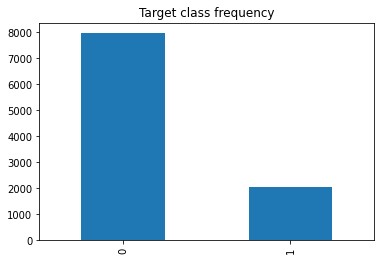

In [18]:
# research on class imbalance
class_freq = target.value_counts()
print(class_freq)
class_freq.plot(kind='bar');
plt.title('Target class frequency');

Наблюдается явный дисбаланс классов. Попробуем это исправить и посмотрим на результаты после. 

Вывод:
Был реализовал перебор гиперпараметров у моделей Дерево решений, Логистическая регрессия и Случайный лес при дисбалансе классов. Лучшее значение f1-меры и AUC показала модель Случайного леса 0.57  и 0.85, соответственно, а худшие метрики оказались у модели Логистической регресии F1-мера: 0.30, AUC ROC: 0.77

## Борьба с дисбалансом

Попробуем протестировать параметр class_weight у модели Случайного леса, а также технику upsampling для редкого класса. 

**LogisticRegression (class_weight='balanced')**

In [19]:
model = LogisticRegression(C=100, random_state=12345, max_iter=100, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
f1 = f1_score(target_valid, predicted_valid)
print("F1-мера:", f1)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("AUC ROC:", auc_roc)

F1-мера: 0.5108601216333623
AUC ROC: 0.7917902494173681


**DecisionTreeClassifier (class_weight='balanced')**

In [20]:
model = DecisionTreeClassifier(criterion="gini", random_state=12345, max_depth=7, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
f1 = f1_score(target_valid, predicted_valid)
print("F1-мера:", f1)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("AUC ROC:", auc_roc)

F1-мера: 0.5691056910569106
AUC ROC: 0.8157140191038496


**RandomForestClassifier (class_weight='balanced')**

In [21]:
model = RandomForestClassifier(random_state=12345, class_weight='balanced')
model.fit(features_train, target_train) 
predicted_valid = model.predict(features_valid)
print(f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("AUC ROC:", auc_roc)

0.5522620904836193
AUC ROC: 0.8493747985273408


Значение f1_score даже немного снизилось, как и значение AUC. Попробуем технику upsampling.

In [22]:
# увеличим класс 1 в 4 раза для паритета с классом 0
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

1    4892
0    4777
Name: Exited, dtype: int64


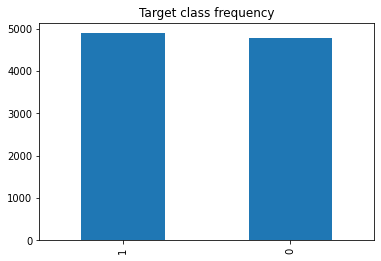

In [23]:
# research on class imbalance after upsampling
class_freq = target_upsampled.value_counts()
print(class_freq)
class_freq.plot(kind='bar');
plt.title('Target class frequency');

**RandomForestClassifier (Upsampled)**

In [24]:
model = RandomForestClassifier(random_state=12345)
model.fit(features_upsampled, target_upsampled) 
predicted_valid = model.predict(features_valid)

print(f1_score(target_valid, predicted_valid))
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("AUC ROC:", auc_roc)

0.5959183673469388
AUC ROC: 0.851502504044877


Значение f1_score стало намного лучше. Теперь приступим к поиску лучшей модели, перебирая различные гиперпараметры. 

**DecisionTreeClassifier (upsampled)**

In [25]:
# let's test DecisionTreeClassifier with various hyperparameters
best_model = None
best_result = 0
best_criterion = None
criterions = ["entropy", "gini"] 
best_depth = 0
# The log_loss option for the parameter criterion was added only in the latest scikit-learn version 1.1.2
for criterion in criterions:
    for depth in range(1, 16):
        model = DecisionTreeClassifier(criterion=criterion, random_state=12345, max_depth=depth)
        model.fit(features_upsampled, target_upsampled) 
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid) 
        if result > best_result:
            best_model = model 
            best_result = result
            best_criterion = criterion
            best_depth = depth
        
print("f1_score наилучшей модели Desion Tree на валидационной выборке:", best_result, 
      'best_depth =', best_depth, 'best_criterion =', best_criterion)

f1_score наилучшей модели Desion Tree на валидационной выборке: 0.5799256505576208 best_depth = 7 best_criterion = entropy


In [26]:
model = DecisionTreeClassifier(criterion="gini", random_state=12345, max_depth=5)
model.fit(features_upsampled, target_upsampled) 
predicted_valid = model.predict(features_valid)

f1 = f1_score(target_valid, predicted_valid)
print("F1-мера:", f1)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("AUC ROC:", auc_roc)

F1-мера: 0.5618556701030928
AUC ROC: 0.8412503412503413


**LogisticRegression (upsampled)**

In [27]:
c_values = [100, 10, 1.0, 0.1, 0.01]

best_model = None
best_result = 0
best_c_value = 0
best_max_iter = 0

for c in c_values:
    for max_iter in range(100, 11000, 1000):
        model = LogisticRegression(C=c, random_state=12345, solver='lbfgs', max_iter=max_iter)
        model.fit(features_upsampled, target_upsampled) 
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        if result > best_result:
            best_model = model 
            best_result = result
            best_c_value = c
            best_max_iter = max_iter
            
print("f1_score модели Logistic Regression на валидационной выборке:", best_result, 
      '\nbest_c_value =', best_c_value, '\nbest_max_iter =', best_max_iter)

f1_score модели Logistic Regression на валидационной выборке: 0.5085910652920962 
best_c_value = 0.1 
best_max_iter = 100


In [28]:
model = LogisticRegression(C=1.0, random_state=12345, max_iter=100, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
f1 = f1_score(target_valid, predicted_valid)
print("F1-мера:", f1)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("AUC ROC:", auc_roc)

F1-мера: 0.5068493150684932
AUC ROC: 0.7918426901477749


**RandomForestClassifier**

In [29]:
# let's test RandomForestClassifier with various hyperparameters
best_rf_model = None
best_result = 0
best_est = 0
best_criterion = None
criterions = ["entropy", "gini"] 
best_depth = 0

for criterion in criterions:
    for est in range(1, 200, 10):
        for depth in range(1, 15):
            model = RandomForestClassifier(criterion=criterion, random_state=12345, n_estimators=est, max_depth=depth) 
            model.fit(features_upsampled, target_upsampled) 
            predicted_valid = model.predict(features_valid)
            result = f1_score(target_valid, predicted_valid)
            if result > best_result:
                best_rf_model = model 
                best_result = result
                best_est = est
                best_criterion = criterion
                best_depth = depth

print("f1_score наилучшей модели Random Forest на валидационной выборке:", best_result, 
      '\nbest_est =', best_est, '\nbest_criterion =', best_criterion, '\nbest_depth =', best_depth)



f1_score наилучшей модели Random Forest на валидационной выборке: 0.640171858216971 
best_est = 141 
best_criterion = gini 
best_depth = 10


Рассчитаем AUC:

AUC ROC: 0.8577560611458916


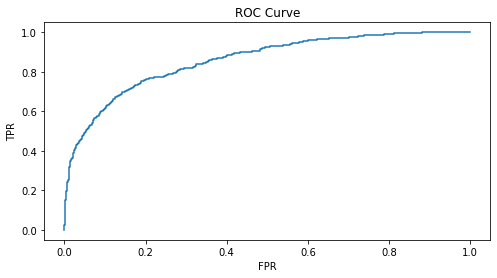

In [30]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("AUC ROC:", auc_roc)

fpr, tpr, thresh = roc_curve(target_valid, probabilities_one_valid)

# create the main graph
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(fpr, tpr)
ax.set_title("ROC Curve")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR");

Лучшая модель - Случайный лес. При этом в разным протестированных моделях значение f1-меры коррелирует со значением auc.

## Тестирование модели

F1-мера: 0.6070991432068544
AUC ROC: 0.8563632970412632


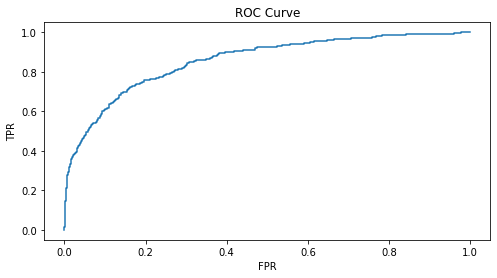

In [31]:
# RandomForestClassifier with the best parameters
model = RandomForestClassifier(criterion='gini', n_estimators=71, max_depth=13, random_state=12345)
model.fit(features_upsampled, target_upsampled) 
predicted_test = model.predict(features_test)

f1 = f1_score(target_test, predicted_test)
print("F1-мера:", f1)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print("AUC ROC:", auc_roc)

fpr, tpr, thresh = roc_curve(target_test, probabilities_one_test)

# create the main graph
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(fpr, tpr)
ax.set_title("ROC Curve")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR");

## Общий вывод

При первичном анализе данных было выявлено, что есть отсутсвующие значения в столбце Tenure, было принято решение заменить их медианой т.к. она более устойчива к выбросам чем, к примеру, среднее. Кроме того, для задачи предсказания оттока клиентов данные столбцов RowNumber', 'CustomerId' и 'Surname' были признаны нерелевантными - RowNumber' и 'CustomerId' не имеют значения сами по себе, а служат для организации информации; столбец 'Surname' нужно удалить также и по этическим соображниям. 

Далее, мы разделели датасет на обучающую, валидационную и тестовую выборки в соотношении 60-20-20. Столбцы с категориальной информацией 'Geography' и 'Gender' были преобразованы с помощью техники One-hot encoding. Столбцы с числовыми данными 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'IsActiveMember', 'EstimatedSalary' стандартизированы с помощью StandardScaler.

На этапе исследования задачи был реализован перебор гиперпараметров у моделей дерево решений, логистическая регрессия и случайный лес. В каждой моделе были подсчитаны F1-мера и значение AUC. Самые высокие значения показала модель Случайный лес: f1_score на валидационной выборке 0.58, AUC 0.86. Также был выявлен дисбаланс целевого класса, соотношение клиентов с расторгнутым контрактом и с действующим различалось, примерно, в 4 раза - 2037 против 7963.

Для борьбы с дисбаланосом были протестированы параметр class_weight со значением balanced у вышеупомянутых моделей, а также техника upsampling для редкого класса. Лучшие результы показала модель Случайный лес с техникой upsampling - значение F1-меры = 0.64, значением AUC ROC = 0.86 на валидационной выборке; и значениями F1-меры = 0.60, и AUC ROC = 0.86 на тествовой выборке. 